# Simulation Overview

This document provides an overview of a Federated Learning (FL) simulation. The simulation includes 10 rounds, involves 30 clients, and utilizes the Federated Averaging (FedAvg) algorithm. The clients are grouped into different federations based on user criteria.

## Key Details

- **Number of Rounds:** 9
- **Number of Clients:** 30
- **Algorithm Used:** Federated Averaging (FedAvg)
- **Federations:** Grouped based on user criteria

## Description

The simulation is designed to illustrate the implementation and performance of a Federated Learning model using the FedAvg algorithm across multiple federations. Each federation represents a subset of the total clients, grouped according to specific user-defined characteristics. The process can be broken down as follows:

### Initialization

1. **Client Distribution:** The 30 clients are divided into various federations based on predefined criteria.
2. **Model Initialization:** A global model is initialized and shared with all clients.

### Federated Learning Process
- **Local Training:** Each client trains the model locally on its own data.
- **Model Updates:** After local training, clients send their model updates to their respective federation.
- **Aggregation:** Within each federation, local updates are aggregated using the FedAvg algorithm to create a federation model.
- **Global Aggregation:** Federation models are further aggregated to update the global model.
- **Model Distribution:** The updated global model is distributed back to all clients for the next round of local training.

This process is made 9 times, one for each round, in order to maximize the accuracy

### Evaluation

- **Performance Metrics:** The performance of the global model is evaluated at the end of each round using relevant metrics (e.g., accuracy, loss).
- **Convergence:** The simulation continues until the model performance stabilizes or the predefined number of rounds is reached.

## Conclusion

This simulation demonstrates the dynamics of Federated Learning with multiple federations using the FedAvg algorithm. By grouping clients into federations based on user criteria, the simulation aims to enhance the efficiency and performance of the learning process.


In [1]:
from typing import Dict, List, Tuple

import tensorflow as tf

import flwr as fl
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
VERBOSE = 0
NUM_CLIENTS = 30

# folder dataset
PATH_TRAIN_X = "../UCI_HAR_Dataset/train/X_train.txt"
PATH_TRAIN_Y = "../UCI_HAR_Dataset/train/y_train.txt"

PATH_TEST_X = "../UCI_HAR_Dataset/test/X_test.txt"
PATH_TEST_Y = "../UCI_HAR_Dataset/test/y_test.txt"

PATH_TRAIN_SBJ = "../UCI_HAR_Dataset/train/subject_train.txt"
PATH_TEST_SBJ = "../UCI_HAR_Dataset/test/subject_test.txt"
PATH_FT = "../UCI_HAR_Dataset/features.txt"

features = pd.read_csv(PATH_FT, sep=" ", header=None, index_col=0).reset_index()

# training X
df_x_train = pd.read_fwf(PATH_TRAIN_X, header=None)
df_x_train.rename(columns=features[1], inplace=True)

# activity subject (train)
df_sbj_train = pd.read_csv(PATH_TRAIN_SBJ, sep=" ", header=None)
df_x_train['user'] = df_sbj_train.values
arr_sbj_train = (df_sbj_train.iloc[:,0]).to_list()
# training Y
y_train_col = pd.read_fwf(PATH_TRAIN_Y, header=None)

# testing X
df_x_test = pd.read_fwf(PATH_TEST_X, header=None)
df_x_test.rename(columns=features[1], inplace=True)
# activity subject (test)
df_sbj_test = pd.read_csv(PATH_TEST_SBJ, sep=" ", header=None)
df_x_test['user'] = df_sbj_test.values
arr_sbj_test = (df_sbj_test.iloc[:,0]).to_list()
# testing Y
y_test_col = pd.read_fwf(PATH_TEST_Y, header=None)

In [3]:
def get_model():
    # model definition
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(features.shape[0],)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [4]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, X_train, X_test, y_train, y_test) -> None:
        super().__init__()
        # Create model
        self.model = get_model()
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.X_train, self.y_train, epochs=3, batch_size=32, verbose=VERBOSE)
        return self.model.get_weights(), len(self.X_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.X_test, self.y_test)
        return loss, len(self.X_test), {"accuracy": float(accuracy)}

In [5]:
def get_client_fn():

    def client_fn(cid) -> fl.client.Client:
        cid = int(cid) + 1

        usr_act_train = []                              # activity made by user (train)
        usr_act_test = []                               # activity made by user (test)

        for i in range(len(arr_sbj_train)):
            if(arr_sbj_train[i] == cid):
                usr_act_train.append(i)
        
        for i in range(len(arr_sbj_test)):
            if(arr_sbj_test[i] == cid):
                usr_act_test.append(i)
        
        df_ext_train = pd.DataFrame(dtype=float)
        df_ext_test = pd.DataFrame(dtype=float)
        y_ext_train = pd.DataFrame(dtype=float)
        y_ext_test = pd.DataFrame(dtype=float)

        for i in range(len(usr_act_train)):
            index = usr_act_train[i]
            x_row = df_x_train.iloc[index,:561]
            df_ext_train = pd.concat([df_ext_train, x_row], ignore_index=True, axis=1)
            y_row = y_train_col.iloc[index]
            y_ext_train = pd.concat([y_ext_train, y_row], ignore_index=True, axis=1)

        for i in range(len(usr_act_test)):
            index = usr_act_test[i]
            x_row = df_x_test.iloc[index,:561]
            df_ext_test = pd.concat([df_ext_test, x_row], ignore_index=True, axis=1)
            y_row = y_test_col.iloc[index]
            y_ext_test = pd.concat([y_ext_test, y_row], ignore_index=True, axis=1)

        df_ext_train = df_ext_train.T
        y_ext_train = y_ext_train.T
        df_ext_test = df_ext_test.T
        y_ext_test = y_ext_test.T

        X_train = np.array(df_ext_train)
        y_train = np.array(y_ext_train)
        X_test = np.array(df_ext_test)
        y_test = np.array(y_ext_test)

        if (len(y_train) == 0) | (len(y_test) == 0):
            if (len(y_train) == 0) & (len(y_test) == 0):
                X_train, X_test, y_train, y_test = np.array()
            else:
                if (len(y_train) == 0):
                    X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, random_state=42, test_size=0.3)
                else:
                    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42, test_size=0.3)
        

        # Create and return client
        return FlowerClient(X_train, X_test, y_train, y_test).to_client()

    return client_fn


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


def get_evaluate_fn(X_test, y_test):
    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ):
        model = get_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(X_test, y_test, verbose=VERBOSE)
        return loss, {"accuracy": accuracy}

    return evaluate

In [6]:
# Enable GPU growth in your main process
enable_tf_gpu_growth()

# Create FedAvg strategy
myStrategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,                   # Sample 10% of available clients for training
    fraction_evaluate=0.05,             # Sample 5% of available clients for evaluation
    min_fit_clients=10,                  # Never sample less than 3 clients for training
    min_evaluate_clients=10,             # Never sample less than 3 clients for evaluation
    min_available_clients=int(
        NUM_CLIENTS
    ),                                  # Wait until at least 30 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    # evaluate_fn=get_evaluate_fn(centralized_testset),  # global evaluation function
)

# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 0.5, "num_gpus": 0}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=30),
    strategy=myStrategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    },
)

INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout
2024-07-11 12:16:21,637	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 2787065856.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 1393532928.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 0.5, 'num_gpus': 0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 16 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(ClientAppActor pid=3041) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the 

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.8438 - loss: 1.2280
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6042 - loss: 1.2288  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8217 - loss: 1.2218  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5534 - loss: 1.3708 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.8262 - loss: 0.7429


(ClientAppActor pid=3041) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 29x across cluster]
(ClientAppActor pid=3041)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 29x across cluster]
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6875 - loss: 0.7512 [repeated 5x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.6760 - loss: 0.9141 [repeated 13x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7256 - loss: 0.7427 [repeated 4x across cluster]
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7031 - loss: 0.7535 [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3039) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 19x across cluster]
(ClientAppActor pid=3039)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 19x across cluster]
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9062 - loss: 0.5086
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7280 - loss: 0.6846  [repeated 8x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9137 - loss: 0.4643 


(ClientAppActor pid=3036) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 9x across cluster]
(ClientAppActor pid=3036)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 9x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.6140 - loss: 0.6194 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3036) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 18x across cluster]
(ClientAppActor pid=3036)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 18x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8426 - loss: 0.2706 [repeated 10x across cluster]


(ClientAppActor pid=3037) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 7x across cluster]
(ClientAppActor pid=3037)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 7x across cluster]
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8865 - loss: 0.2213  [repeated 16x across cluster]


(ClientAppActor pid=3027) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 27x across cluster]
(ClientAppActor pid=3027)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 27x across cluster]
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.7669 - loss: 0.3803 [repeated 3x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8438 - loss: 0.4805
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8047 - loss: 0.5709


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3039) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 23x across cluster]
(ClientAppActor pid=3039)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 23x across cluster]
(ClientAppActor pid=3027) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 7x across clu

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9821 - loss: 0.1860   [repeated 10x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7711 - loss: 0.6491  [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3037) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 21x across cluster]
(ClientAppActor pid=3037)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 21x across cluster]


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9062 - loss: 0.4027
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.8947 - loss: 0.3805
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7686 - loss: 0.3459  [repeated 10x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8138 - loss: 0.3700  


(ClientAppActor pid=3037) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 4x across cluster]
(ClientAppActor pid=3037)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 4x across cluster]


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8125 - loss: 0.3582


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9627 - loss: 0.2228   [repeated 10x across cluster]


(ClientAppActor pid=3037) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 20x across cluster]
(ClientAppActor pid=3037)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 20x across cluster]


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9375 - loss: 0.1385
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9453 - loss: 0.1506
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9603 - loss: 0.1492


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3040) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 12x across cluster]
(ClientAppActor pid=3040)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 12x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8330 - loss: 0.3458  [repeated 7x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3037) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 16x across cluster]
(ClientAppActor pid=3037)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 16x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9796 - loss: 0.1453   [repeated 10x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 1.0000 - loss: 0.0783
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9938 - loss: 0.0930  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3028) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 22x across cluster]
(ClientAppActor pid=3028)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 22x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3027) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a laye

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8562 - loss: 0.2855   [repeated 8x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.8750 - loss: 0.3363
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8652 - loss: 0.3383  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3028) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 18x across cluster]
(ClientAppActor pid=3028)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 18x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3039) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a laye

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0197
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6203 - loss: 2.2622  [repeated 9x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0342  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.9718 - loss: 0.0775


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3027) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 19x across cluster]
(ClientAppActor pid=3027)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 19x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9688 - loss: 0.0631 [repeated 2x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9010 - loss: 0.1757  [repeated 8x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9640 - loss: 0.0941 


(ClientAppActor pid=3038) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 7x across cluster]
(ClientAppActor pid=3038)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 7x across cluster]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9393 - loss: 0.1857   [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3028) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 16x across cluster]
(ClientAppActor pid=3028)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 16x across cluster]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0625   [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3027) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 8x across cluster]
(ClientAppActor pid=3027)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 8x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8255 - loss: 1.1707  [repeated 8x across cluster]
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8438 - loss: 0.3375
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8545 - loss: 0.2862  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3035) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 20x across cluster]
(ClientAppActor pid=3035)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 20x across cluster]
(ClientAppActor pid=3038) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 3x across cl

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.9287 - loss: 0.2768 [repeated 8x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7500 - loss: 1.3399
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.7656 - loss: 1.3823
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7727 - loss: 1.3924


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8581 - loss: 0.3402 [repeated 6x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.7500 - loss: 0.3398
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8140 - loss: 0.2829


(ClientAppActor pid=3034) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 17x across cluster]
(ClientAppActor pid=3034)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 17x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0645  [repeated 4x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.8750 - loss: 0.5243
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8833 - loss: 0.5571  


(ClientAppActor pid=3027) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 18x across cluster]
(ClientAppActor pid=3027)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 18x across cluster]
(ClientAppActor pid=3040) WARNING:tensorflow:5 out of the last 14 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x2dc3c6e80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9031 - loss: 0.2058   [repeated 8x across cluster]


(ClientAppActor pid=3028) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 10x across cluster]
(ClientAppActor pid=3028)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 10x across cluster]


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 1.0000 - loss: 0.1195
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9767 - loss: 0.1756  


(ClientAppActor pid=3036) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 3x across cluster]
(ClientAppActor pid=3036)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 3x across cluster]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9717 - loss: 0.1030   [repeated 2x across cluster]
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - accuracy: 0.9375 - loss: 0.1582
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9388 - loss: 0.1514 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3037) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 13x across cluster]
(ClientAppActor pid=3037)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 13x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8943 - loss: 0.2702   [repeated 6x across cluster]


(ClientAppActor pid=3035) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 8x across cluster]
(ClientAppActor pid=3035)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 8x across cluster]
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3027) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 4x across clus

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8202 - loss: 0.3104   [repeated 10x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9688 - loss: 0.0614
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9609 - loss: 0.0807
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6358 - loss: 1.7482 


(ClientAppActor pid=3037) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 11x across cluster]
(ClientAppActor pid=3037)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 11x across cluster]
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3038) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 7x across cl

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9219 - loss: 0.2379   [repeated 8x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.5938 - loss: 1.8271
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9665 - loss: 0.0797 
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step - accuracy: 0.9688 - loss: 0.1701
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8672 - loss: 0.3707
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8443 - loss: 0.4567 


(ClientAppActor pid=3028) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 10x across cluster]
(ClientAppActor pid=3028)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 10x across cluster]


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9691 - loss: 0.1252  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3036) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 14x across cluster]
(ClientAppActor pid=3036)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 14x across cluster]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9830 - loss: 0.0729   [repeated 8x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8750 - loss: 0.3172
2/4 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step - accuracy: 0.8594 - loss: 0.3069
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.8543 - loss: 0.2996


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3038) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 10x across cluster]
(ClientAppActor pid=3038)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 10x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3034) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a laye

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9845 - loss: 0.0377   [repeated 8x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.6875 - loss: 2.1979
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6981 - loss: 2.0866  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3027) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 20x across cluster]
(ClientAppActor pid=3027)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 20x across cluster]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9022 - loss: 0.5226   [repeated 10x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step - accuracy: 0.8125 - loss: 1.6996
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8038 - loss: 1.8394  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3037) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 14x across cluster]
(ClientAppActor pid=3037)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 14x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9753 - loss: 0.1406   [repeated 9x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 0.9688 - loss: 0.0865
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9553 - loss: 0.1112  


(ClientAppActor pid=3028) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 10x across cluster]
(ClientAppActor pid=3028)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 10x across cluster]
(ClientAppActor pid=3035) WARNING:tensorflow:5 out of the last 14 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x2e786cea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0158   [repeated 8x across cluster]
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9688 - loss: 0.2191
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9336 - loss: 0.2747  
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step - accuracy: 0.8750 - loss: 1.2609
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8503 - loss: 1.3392  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3028) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 20x across cluster]
(ClientAppActor pid=3028)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 20x across cluster]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8590 - loss: 0.3452   [repeated 9x across cluster]


(ClientAppActor pid=3027) WARNING:tensorflow:5 out of the last 14 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x2df9fed40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(ClientAppActor pid=3028) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `In

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9144 - loss: 0.1624   [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=3037) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 7x across cluster]
(ClientAppActor pid=3037)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 7x across cluster]
(ClientAppActor pid=3028) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across clus

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9033 - loss: 0.5112   [repeated 6x across cluster]


(ClientAppActor pid=3037) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 14x across cluster]
(ClientAppActor pid=3037)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 14x across cluster]
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 332.19s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.2250351382626428
INFO :      		round 2: 0.8122181384479953
INFO :      		round 3: 0.589096490530773
INFO :      		round 4: 0.4495057146317563
INFO :      		round 5: 0.36945050768909
INFO :      		round 6: 0.3831827104698087
INFO :      		round 7: 0.46017297500339244
INFO :      		round 8: 0.43083918

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9354 - loss: 0.2467  

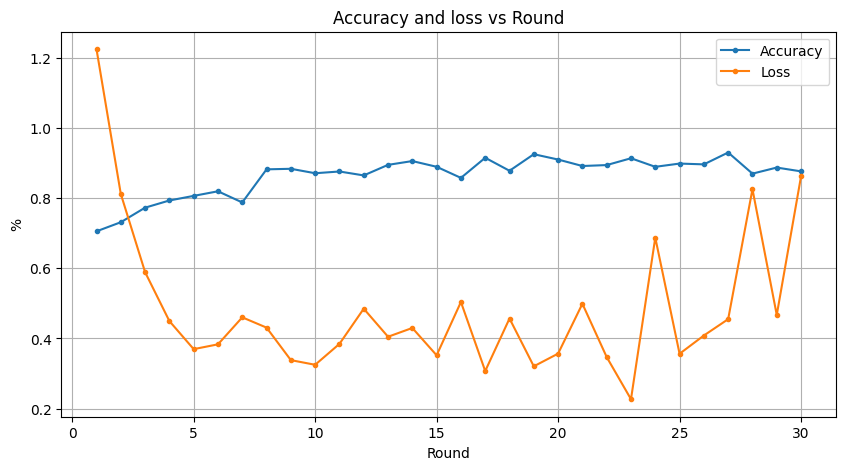

In [7]:
acc = pd.DataFrame(history.metrics_distributed["accuracy"])
loss = pd.DataFrame(history.losses_distributed)

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(acc[0], acc[1], marker='.', label='Accuracy')
plt.plot(loss[0], loss[1], marker='.', label='Loss')
plt.xlabel('Round')
plt.ylabel('%')
plt.title('Accuracy and loss vs Round')
plt.grid(True)
plt.legend()
plt.show()